## Web Scraper - IMFD Taller Periodistas 2019
Se obtendrán datos de fuentes de oferta inmobiliaria

#### Fuentes:
1. www.portalinmobiliario.com
2. http://www.propiedades.emol.com
3. www.zoominmobiliario.com

El objetivo es obtener ofertas inmobiliarias enfocadas en la clase media Chilena (C1b, C2, C3).

#### Supuestos de la clase media:
- Ingresos mensuales entre 900.000 y 2.000.000 CLP.
- Préstamo inmobiliario a 25 o hasta 40 años.
- persona Chilena promedio gasta en promedio 40% a 60% del sueldo en vivienda (360.000 a 1.200.000)
- Precio de compra entre 2500 y 4000 UFs.
- Arriendo entre 360.000 y 1.200.000 CLP (UF 13.0 a 44.0).

Tutoriales:
1. Selenium Web Scraping: https://medium.com/the-andela-way/introduction-to-web-scraping-using-selenium-7ec377a8cf72
2. GeckoDriver: https://askubuntu.com/questions/870530/how-to-install-geckodriver-in-ubuntu
3. Selenium: https://selenium-python.readthedocs.io/installation.html
4. Google Places: https://developers.google.com/places/web-service/search
5. Google Maps: https://developers.google.com/maps/documentation/geocoding/start

In [72]:
import sys

from selenium import webdriver 
from selenium.webdriver.common.by import By 
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC 
from selenium.common.exceptions import TimeoutException

from selenium.webdriver.chrome.options import Options
chrome_options = Options()
chrome_options.add_argument("--headless")

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

----
### Portal Inmobiliario

#### Variables

A continuación están las variables para los filtros y los tipos de propiedades que queremos obtener

In [3]:
# Variables

# Purchase min and max values
price_down = '2.500'
price_high = '4.000'

# Purchase min and max values
rent_min = '13'
rent_max = '44'

# First is dptos (pages[0]), second houses(pages[1])
# The inside bracket: first purchase (pages[0][0], pages[1][0]), second renting (pages[0][1], pages[1][1])
pages = [[199, 358],[113, 61]]

tipos = ['departamento', 'casa']

#### Generar URLs

Al tener los filtros, debemos armar la lista de las URLs que queremos scrapear según el tipo de pago, tipo de vivienda y finalmente, iterar sobre el número de páginas de casa caso.

In [4]:
urls = []
for i in range(len(tipos)):
    t = tipos[i]
    # Buy
    for p in range(1, pages[i][0]+1):
        urls.append("https://www.portalinmobiliario.com/venta/"+t+"/metropolitana?pd="+price_down+"&ph="+price_high+"&pg="+str(p))
    # Rent
    for p in range(1, pages[i][1]+1):
        urls.append("https://www.portalinmobiliario.com/arriendo/"+t+"/metropolitana?pd="+rent_min+"&ph="+rent_max+"&pg="+str(p))
    

#### Descargar HTMLs
Para evitar tener que hacer llamadas a la página múltiples veces, lo mejor es descargar los HTMLs de las propiedades que se desean scrapear. Primero, guardamos los HTMLs de las listas de ofertas.

In [13]:
browser = webdriver.Chrome(options=chrome_options)
directory = './html_p_inmobiliario_30-08-2019/'

for number, u in enumerate(urls):
    browser.get(u)
    titles_element = browser.find_elements_by_class_name('product-item-data')
    
    
    for index, prop in enumerate(titles_element):
        html = prop.get_attribute('outerHTML')
        
        purchase = 'venta' if 'venta' in u else 'arriendo'
        elem_type = 'casa' if 'casa' in u else 'departamento'
        
        filename = directory + purchase + '_' + elem_type + '_url' + str(number) + '_index' + str(index) + '.html'
        # print(filename)
        
        f = open(filename, 'a')
        f.write(html)
        f.close()

In [14]:
browser.close()

#### HTMLs de las Vistas
El siguiente paso es iterar las listas y guardar latitud y longitud para cada propiedad.

Primero, leemos el archivo de *geolocation* anterior para evitar leer propiedades ya revisadas.

In [12]:
import json

geoloc_prev = open('geoloc_parte1.json')
geoloc_prev = geoloc_prev.read()
geoloc_prev = json.loads(geoloc_prev)


len(geoloc_prev)

13545

In [8]:
browser = webdriver.Chrome(options=chrome_options)
unit_browser = webdriver.Chrome(options=chrome_options)
url_folder = 'html_p_inmobiliario_30-08-2019/'
directory = 'html_vistas_p_inmobiliario_30-08-2019/'

host = 'https://www.portalinmobiliario.com/'

import os

geoloc = {}
not_working = set()

for number, filename in enumerate(os.listdir('./'+url_folder)):
    if(not(filename in geoloc_prev)):  
        try:
            # Read saved HTML
            pwd = os.getcwd()
            filepath = url_folder + filename
            html_file = 'file://' + os.getcwd() + "/" + filepath
            browser.get(html_file)

            # Get href
            link = (browser.find_element_by_tag_name('a').get_attribute("href"))[8:]

            # Open property view
            try:
                unit_browser.get(host+link)
            except:
                print("Reopen Unit Browser")
                unit_browser = webdriver.Chrome(options=chrome_options)
                

            # Get geoloc
            latitud = unit_browser.find_element_by_xpath("//meta[@property='og:latitude']").get_attribute('content')
            longitud = unit_browser.find_element_by_xpath("//meta[@property='og:longitude']").get_attribute('content')
            geoloc[filename] = [float(latitud), float(longitud)]
            
        except:
            e = sys.exc_info()
            print(filename)
            not_working.add(filename)
            
browser.close()
unit_browser.close()

arriendo_departamento_url546_index1.html
arriendo_departamento_url336_index4.html
arriendo_departamento_url472_index5.html
venta_departamento_url62_index3.html
arriendo_departamento_url536_index6.html
venta_casa_url598_index4.html
arriendo_departamento_url250_index6.html
arriendo_departamento_url350_index17.html
arriendo_departamento_url381_index8.html
arriendo_departamento_url418_index0.html
arriendo_departamento_url257_index16.html
venta_casa_url664_index8.html
arriendo_departamento_url480_index21.html
arriendo_departamento_url319_index21.html
venta_casa_url664_index18.html
venta_departamento_url192_index21.html
arriendo_departamento_url259_index18.html
arriendo_departamento_url369_index7.html
venta_departamento_url71_index21.html
arriendo_departamento_url367_index18.html
arriendo_departamento_url263_index7.html
arriendo_departamento_url368_index15.html
arriendo_departamento_url259_index22.html
venta_departamento_url151_index17.html
arriendo_departamento_url354_index5.html
arriendo_d

arriendo_departamento_url295_index11.html
arriendo_departamento_url485_index12.html
arriendo_departamento_url309_index8.html
arriendo_departamento_url328_index12.html
arriendo_departamento_url381_index15.html
arriendo_departamento_url395_index14.html
arriendo_departamento_url315_index23.html
arriendo_departamento_url219_index7.html
venta_departamento_url164_index5.html
venta_departamento_url19_index8.html
arriendo_departamento_url502_index2.html
arriendo_departamento_url264_index12.html
arriendo_departamento_url376_index16.html
arriendo_departamento_url369_index23.html
venta_departamento_url88_index21.html
arriendo_departamento_url482_index12.html
venta_departamento_url73_index12.html
venta_departamento_url172_index19.html
arriendo_casa_url713_index10.html
arriendo_departamento_url245_index23.html
venta_casa_url660_index18.html
venta_departamento_url191_index21.html
arriendo_departamento_url396_index11.html
arriendo_casa_url701_index10.html
venta_casa_url619_index8.html
arriendo_depart

arriendo_departamento_url430_index18.html
arriendo_departamento_url358_index5.html
arriendo_departamento_url441_index19.html
arriendo_casa_url691_index16.html
venta_departamento_url152_index8.html
arriendo_departamento_url313_index22.html
arriendo_departamento_url400_index4.html
venta_departamento_url150_index5.html
arriendo_departamento_url548_index20.html
venta_departamento_url118_index19.html
venta_casa_url648_index15.html
arriendo_departamento_url498_index0.html
venta_departamento_url40_index4.html
arriendo_departamento_url295_index22.html
arriendo_departamento_url333_index21.html
arriendo_departamento_url238_index21.html
arriendo_departamento_url204_index24.html
arriendo_departamento_url237_index8.html
venta_departamento_url43_index4.html
venta_departamento_url56_index12.html
arriendo_departamento_url276_index18.html
arriendo_departamento_url358_index7.html
arriendo_departamento_url327_index2.html
venta_departamento_url149_index1.html
venta_departamento_url111_index16.html
venta_d

arriendo_departamento_url283_index18.html
arriendo_departamento_url349_index6.html
arriendo_departamento_url389_index17.html
arriendo_departamento_url219_index14.html
arriendo_departamento_url269_index7.html
venta_departamento_url26_index11.html
arriendo_departamento_url436_index5.html
arriendo_departamento_url301_index16.html
arriendo_departamento_url323_index19.html
venta_departamento_url135_index9.html
arriendo_departamento_url468_index4.html
arriendo_departamento_url306_index5.html
arriendo_departamento_url272_index19.html
venta_departamento_url159_index11.html
arriendo_departamento_url282_index18.html
arriendo_departamento_url472_index15.html
arriendo_departamento_url306_index8.html
venta_casa_url660_index16.html
arriendo_departamento_url502_index11.html
venta_departamento_url197_index4.html
venta_casa_url652_index10.html
arriendo_departamento_url268_index2.html
venta_departamento_url143_index3.html
venta_casa_url660_index19.html
arriendo_departamento_url459_index21.html
arriendo_

arriendo_casa_url705_index22.html
arriendo_departamento_url554_index18.html
arriendo_departamento_url415_index6.html
venta_casa_url557_index19.html
arriendo_departamento_url353_index7.html
arriendo_casa_url714_index18.html
arriendo_departamento_url415_index13.html
venta_departamento_url13_index19.html
arriendo_departamento_url482_index9.html
arriendo_departamento_url216_index19.html
venta_casa_url607_index11.html
venta_departamento_url176_index7.html
arriendo_casa_url677_index8.html
arriendo_departamento_url471_index14.html
arriendo_departamento_url389_index22.html
arriendo_departamento_url251_index10.html
arriendo_departamento_url293_index18.html
arriendo_casa_url672_index19.html
arriendo_casa_url726_index4.html
arriendo_casa_url670_index24.html
venta_casa_url661_index4.html
arriendo_departamento_url296_index21.html
arriendo_departamento_url207_index23.html
venta_casa_url624_index17.html
venta_departamento_url193_index20.html
venta_departamento_url45_index1.html
arriendo_departamento_

In [9]:
import os
len(os.listdir('./'+url_folder))

18243

In [77]:
len(geoloc)

13545

In [24]:
geoloc = {**geoloc_prev, **geoloc}
len(geoloc)

13545

In [25]:
import json

json = json.dumps(geoloc)
f = open('geoloc_parte1.json','w')
f.write(json)
f.close()

#### Obtener Datos
Al tener ya los HTMLs, el siguiente paso es sacar los datos usando técnicas de scraping y manejo de strings

In [98]:
# Get data
browser = webdriver.Chrome(options=chrome_options)

url_folder = 'html_p_inmobiliario_30-08-2019/'

not_working = set()
p_inmobiliario = []


for number, filename in enumerate(os.listdir('./'+url_folder)):
    # Read saved HTML
    pwd = os.getcwd()
    filepath = url_folder + filename
    html_file = 'file://' + os.getcwd() + "/" + filepath
    # print(filename)
        
    try:
        try:
            browser.get(html_file)
        except:
            print('REOPEN\n')
            browser = webdriver.Chrome(options=chrome_options)
            browser.get(html_file)
            
        # Find all offers' data
        unit_element = browser.find_element_by_class_name('product-item-data')
        data = unit_element.text.split('\n')

        # Reset variables
        code = 0 
        addr = 'None'
        comuna = 'None'
        lat = 0.0
        lon = 0.0
        rooms = 'None'
        price_min = 0.0
        price_max = 0.0
        size_min = 0.0
        size_max = 0.0
        purchase = 'None'
        elem_type = 'None'
        project_type = 'None'
        
        
        # Get property's info
        project_type = data[0].split(',')[0]
        purchase = data[0].split(',')[1]
        elem_type = data[0].split(',')[2]

        if 'Proyecto' in data[0]:
            data = data[2:]
        elif('D' in data[3] or 'B' in data[3]):
            rooms = data[3]
            data = data[1:3] + data[4:] 
        else:
            data = data[1:]
            
        # Get Address
        addr = data[0]

        # Get Code
        code = int(data[1].split()[1])

        # Get Comuna
        comuna = addr.split(',')[-1].strip()

        # Check if file name is in the `geoloc` dictionary
        if filename in geoloc.keys():
            # Get Geolocation
            geo = geoloc[filename]
            lat = geo[0]
            lon = geo[1]
        else:
            not_working.add(filename)
        
        
        # Get value or min_price
        if(hasNumbers(data[2])):
            price_min = float(data[2].split(',')[0].split()[-1].replace(".", ''))
        else:
            price_min = float(data[3].split(',')[0].replace("UF ", "").replace(".", ''))
        
        
        # Check if there's a max price
        if(len(data) > 3 and 'Hasta:' in data[3]):
            price_max = float(data[3].split(',')[0].split()[-1].replace(".", ''))
                        
        values = [0.0, 0.0]
        
        
        # Manage cases with just price_min and of length below 4
        if(len(data) > 3 and 'Superficie:' in data[3]):
            surface = data[3].replace(",", ".").split()
            size_min = float(surface[1])

            # Check if there's a max size
            if(len(surface) > 3):
                size_max = float(surface[3])
                            
        # Check cases with length 4 or over
        if(len(data) > 4):
            # Check if there's "hasta" price
            if('Hasta:' in data[4]):
                price_max = float(data[5].split(',')[0].replace("UF ", "").replace(".", ''))
                values = data[7].replace(",", ".").split()

            elif('Superficie:' in data[4]):
                surface = data[4].replace(",", ".").split()
                size_min = float(surface[1])

                # Check if there's a max size
                if(len(surface) > 3):
                    size_max = float(surface[3])
        
        p_inmobiliario.append([code, addr, comuna, lat, lon, rooms, price_min, price_max, size_min, size_max, purchase, elem_type, project_type])
        # print(p_inmobiliario[-1])

    except:
        e = sys.exc_info()
        print(filename)
        print(e)
        print(html_file)
        print(unit_element.text.split('\n'))
        print(data)
        print('\n')
            
browser.close()

venta_casa_url610_index17.html
(<class 'ValueError'>, ValueError("could not convert string to float: '2.940.000'"), <traceback object at 0x7f78678adb48>)
file:///home/francesca/imfd-taller/html_p_inmobiliario_30-08-2019/venta_casa_url610_index17.html
['Propiedad usada, Venta, Casa', 'las lagunas 130, Til Til', 'CÃģdigo: 4993213', '3D/2B', 'Valor: UF 3.200,00', 'Superficie: 80 - 2.940.000 mÂē']
['las lagunas 130, Til Til', 'CÃģdigo: 4993213', 'Valor: UF 3.200,00', 'Superficie: 80 - 2.940.000 mÂē']




Formato de los datos en `p_inmobiliario`:

| Código | Dirección | Comuna | Latitud | Longitud | Piezas | Precio Min (UF) | Precio Max (UF) | Tamaño Min (m<sup>2</sup>) | Tamaño Max (m<sup>2</sup>) | Pago | Tipo de Vivienda | Tipo Proyecto |
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----|
| 12345 | Vicuña Mackenna 3030, Macul | Macul| -33 | -70 | None | 2400.0 | 3000.0 | 37.0 | 38.0 | Venta | Departamento |  Proyecto |
| 12346 | Marberia 476, Las Condes | Las Condes | -33 | -70 | 3D2B | 28.0 | 0.0 | 25.0 | 0.0 | Arriendo | Casa | Propiedad Usada |

----

Algunas propiedades no tienen algunos datos. Lo que se hizo es lo siguiente:
1. Si sólo tiene un valor para el precio (Precio Min): Precio Max toma valor 0.0
2. Si sólo tiene un valor para la superficie (Tamaño Min): Tamaño Max toma valor 0.0
3. Si no tiene información sobre las piezas: Piezas toma valor None
4. Si no tiene valores de latitud y longitud: ambos se reemplazan por 0.0

#### Guardar Datos

Lo siguiente es guardar los datos en un csv:

In [100]:
import csv
import datetime

# Add current date to CSV's filename
now = '{0:d%Y-%m-%d_t%H-%M-%S}'.format(datetime.datetime.now())
filename = "p_inmobiliario_"+now+"_completo.csv"

with open(filename, 'w', newline="") as myfile:
    wr = csv.writer(myfile)
    wr.writerow(['Codigo', 'Direccion', 'Comuna', 'Latitud', 'Longitud', 'Piezas', 'Precio Min (UF)', 'Precio Max (UF)', 'Tamaño Min', 'Tamaño Max', 'Pago', 'Tipo de Vivienda', 'Tipo Proyecto'])
    wr.writerows(p_inmobiliario)

#### Mapas
Después de obtener los datos, debemos mostrarlos en el mapa. Lo primero es cargar los datos guardados.

In [41]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import pyproj

y_lim = (-32.7,-34.3) # latitude 
x_lim = (-71.75, -69.75) # longitude
_projections = {}
zone = 19
l = 'S'

table = pd.read_csv('p_inmobiliario_d2019-09-04_t20-04-18_completo.csv')
table.sample(5)

,Codigo,Direccion,Comuna,Latitud,Longitud,Piezas,Precio Min (UF),Precio Max (UF),Tamaño Min,Tamaño Max,Pago,Tipo de Vivienda,Tipo Proyecto
9580,5009654,"Metro COLON, Las Condes",Las Condes,-33.42573,-70.59078,3D/3B,23,0,100.0,120.0,Arriendo,Departamento,Propiedad usada
8788,5006696,"METRO EL GOLF, Las Condes",Las Condes,-33.41780,-70.59210,1D/1B,16,0,42.0,0.0,Arriendo,Departamento,Propiedad usada
9805,4968607,"metro / el vergel, Providencia",Providencia,-33.42835,-70.58994,2D/2B,25,0,90.0,96.0,Arriendo,Departamento amoblado,Propiedad usada
13328,5017025,"Metro Irarrázaval - Jose Domingo Cañas, Ñuñoa",Ñuñoa,-33.45490,-70.62510,2D/2B,17,0,76.0,76.0,Arriendo,Departamento,Propiedad usada
17294,4958888,"Av Padre Hurtado / La Serena, El Bosque",El Bosque,-33.57517,-70.67230,4D/1B,2683,0,140.0,190.0,Venta,Casa,Propiedad usada


Lo siguiente es cargar escribir las funciones necesarias para dibujar el mapa:

In [42]:
# Translate UTM to Lat/Lon Coords.
def unproject(x, y, z=zone, l=l):
    if z not in _projections:
        _projections[z] = pyproj.Proj(proj='utm', zone=z, ellps='WGS84')
    if l > 'N':
        y -= 10000000
    lng, lat = _projections[z](x, y, inverse=True)
    return (lng, lat)

In [43]:
# Map configuration
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))
%matplotlib inline

# Open .shp files
shp_path = "./comunas/comunas.shp"
sf = shp.Reader(shp_path, encoding="latin1")

In [44]:
# Function used to read .shp files
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return(df)

In [45]:
def plot_map(sf, geoloc, x_lim = None, y_lim = None, figsize=(11,9)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    
    # Plot sf
    id=0
    for shape in sf.shapeRecords():
        x = []
        y = []
        points = shape.shape.points[:]
        for i in points:
            xi, yi = unproject(i[0], i[1])
            x.append(xi)
            y.append(yi)

        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    # Plot geoloc
    for elem in geoloc:
        geo = geoloc[elem]
        plt.plot(geo[1],geo[0], 'ro')
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

Mostramos el mapa de la Región Metropolitana con las propiedades:

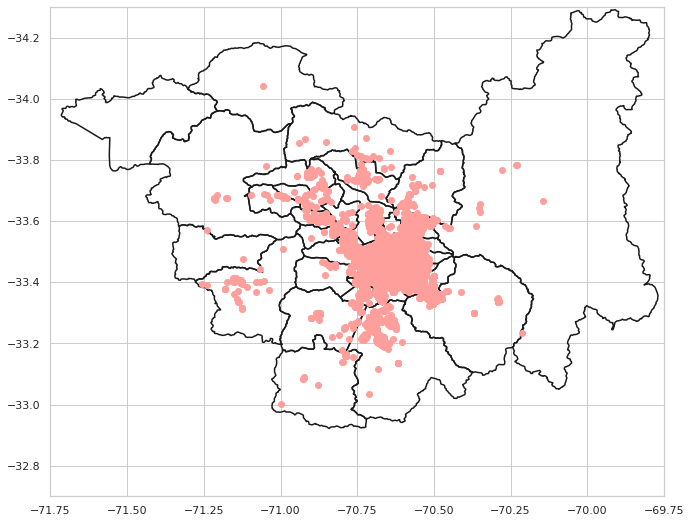

In [46]:
import json

geoloc = open('geoloc_parte1.json')
geoloc = geoloc.read()
geoloc = json.loads(geoloc)

rm_comunas = read_shapefile(sf)
plot_map(sf, geoloc, x_lim=x_lim, y_lim=y_lim)

#### Mapa de Calor